In [1]:
from dolfin import *
from rbnics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Poroelasticity(ParabolicCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        ParabolicCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        U = TrialFunction(V)
        (self.u, self.µ) = split(U)
        V_ = TestFunction(V)
        (self.v, self.q) = split(V_)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        self.µ_init = -0.3124
        self.µ_swell = -0.001
        self.alpha = 0.66  # value for robin boundary coefficient
        # Store the initial condition expression
        self.ic = project(InitialConditions(), self.V)

    # Return custom problem name
    def name(self):
        return "GelsMOR_Bar_nestedPOD_0427"

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "m":
            theta_m0 = 1.
            return (theta_m0, )
        elif term == "a":
            theta_a0 = 2.
            theta_a1 = mu[0]
            theta_a2 = -mu[1]
            theta_a3 = 1.
            theta_a4 = self.alpha
            return (theta_a0, theta_a1, theta_a2, theta_a3,theta_a4,)
        elif term == "f":
            theta_f0 = self.alpha * self.µ_swell
            theta_f1 = -mu[1] * self.µ_init
            return (theta_f0,theta_f1,)
        elif term == "initial_condition":
            # Create intial conditions and interpolate
            u_init = 1.0
            theta_ic0 = u_init
            return (theta_ic0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        q = self.q
        dx = self.dx
        if term == "m":
            u = self.u
            m0 = tr( sym( grad(u)) )* q * dx
            return (m0,)
        elif term == "a":
            u = self.u
            µ = self.µ
            ds = self.ds
            alpha = self.alpha
            # sig = 2*sym(grad(u)) + ( lmbda*tr(sym(grad(u))) - A*(µ-µ_swell) )*Identity(mesh.topology().dim())
            # sig = self.elasticity(lmbda, A, u, µ)
            a0 = inner( sym(grad(u)), sym(grad(v)) ) * dx
            a1 = inner(tr(sym(grad(u))) * Identity(mesh.topology().dim()), sym(grad(v)) ) * dx
            a2 = inner(µ*Identity(mesh.topology().dim()), sym(grad(v)) ) * dx
            a3 = dot(grad(µ), grad(q)) * dx
            a4 = µ * q* ds(2) #+  µ * q* ds(6)# +  µ * q* ds(4)
            return (a0, a1, a2, a3, a4,)
        elif term == "f":
            ds = self.ds
            f0 = q * ds(2) + q * ds(1) + q * ds(4)
            f1 = inner( Identity(mesh.topology().dim()), sym(grad(v)) )*dx
            return (f0,f1,)
        elif term == "initial_condition":
            ic0 = self.ic
            return (ic0,)
        elif term == "dirichlet_bc":
            # bc0 = [DirichletBC(self.V.sub(0).sub(1), Constant(0.0), self.boundaries, 4)]
            bc0 = [DirichletBC(self.V.sub(0).sub(0), Constant(0.0), self.boundaries, 3)]
            # bc0 = []
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            µ = self.µ
            x0 = inner(u, v) * dx +  inner(µ,q)*dx
            return (x0,)
        elif term == "projection_inner_product":
            u = self.u
            µ = self.µ
            x0 = inner(u, v) * dx +  inner(µ,q)*dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")
        

# Class representing the intial conditions
class InitialConditions(UserExpression):
    def eval(self, values, x):
        values[0] = 0.0                 # ux
        values[1] = 0.0                 # uy
        values[2] = -0.3124        # mu
    def value_shape(self):
        return (3,)

    
# New model setup with halved domain in the x-direction
L = 1  # Thickness of the plate
N = 100  # Mesh density
domain = Rectangle(Point(0., 0.), Point(0.5*L, 4*L))  # Halved domain dimensions in x-direction
mesh = generate_mesh(domain, N)
n = FacetNormal(mesh)

# Define boundary conditions
class Left1(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0) and x[1] > 0.25*(4*L)

class Left2(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0) and x[1] <= 0.75*(4*L)

class RightSymmetry(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.5*L)

class Top(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 4*L)

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0)

# Add boundaries
left1 = Left1()
left2 = Left2()
right_symmetry = RightSymmetry()
top = Top()
bottom = Bottom()

subdomains = MeshFunction("size_t", mesh, mesh.topology().dim(), 0)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
left1.mark(boundaries, 1)
left2.mark(boundaries, 2)
right_symmetry.mark(boundaries, 3)
top.mark(boundaries, 4)
bottom.mark(boundaries, 5)

Identity(mesh.topology().dim()) 

### Field variable function spaces
element_u = VectorElement('CG', mesh.ufl_cell(), 2) # displacement finite element
element_µ = FiniteElement('CG', mesh.ufl_cell(), 1) # chemical potential finite element
V = FunctionSpace(mesh, MixedElement([element_u, element_µ]))

problem = Poroelasticity(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(1000, 2000), (2000, 6000),]
final_sim_time = 0.25
time_step_size = final_sim_time/100
problem.set_mu_range(mu_range)
problem.set_time_step_size(time_step_size)
problem.set_final_time(final_sim_time)

reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20, nested_POD=8)
# reduction_method.set_tolerance(1e-8, nested_POD=1e-4)
reduction_method.initialize_training_set(30)
reduced_problem = reduction_method.offline()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FF

### Perform an online solve

In [3]:
online_mu = (1558, 4000)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()
# plot(reduced_solution, reduced_problem=reduced_problem, every=5, interval=500)

In [4]:
time_instance = 100
reduced_solution_at_time_instance = reduced_solution[time_instance]  # this is OnlineVector
type( reduced_solution_at_time_instance )

rbnics.backends.online.basic.function.Function.<locals>._Function_Type

In [5]:
reconstructed_reduced_solution_at_time_instance = reduced_problem.basis_functions[:reduced_solution_at_time_instance.N] * reduced_solution_at_time_instance  # this is a dolfin Function
type( reconstructed_reduced_solution_at_time_instance )
( u_time,µ_time ) = split(reconstructed_reduced_solution_at_time_instance)

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from labellines import labelLines
from matplotlib.ticker import MaxNLocator

# Create the directory to save figures if it doesn't exist
save_dir = "results/ROM/UQ_plots"
os.makedirs(save_dir, exist_ok=True)

# Initialize the initial chemical potential
µ_init = -0.3124

# Define strain and stress functions
def eps(u):
    return sym(grad(u))

def sigma(u, µ):
    return 2 * eps(u) + (lmbda * tr(eps(u)) - A * (µ - µ_init)) * Identity(mesh.topology().dim())

# Generate random parameter list using Gaussian distribution
nominal_lambda = 1558
nominal_A = 4000
std_lambda = 0.10 * nominal_lambda
std_A = 0.10 * nominal_A
np.random.seed(42)  # For reproducibility

num_realizations = 1000  # Number of realizations to generate
parameter_list = [
    (np.random.normal(nominal_lambda, std_lambda), np.random.normal(nominal_A, std_A))
    for _ in range(num_realizations)
]

# Initialize result containers
results = {
    'displacement_x': [],
    'displacement_y': [],
    'chemical_potential': [],
    'mean_stress_xx': [],
    'max_stress_xx': [],
    'mean_stress_yy': [],
    'max_stress_yy': []
}

# Define specific points within the domain for plotting
points_of_interest = [(0.0, 0.0), (0.5, 0.0)]  # Adjust based on your problem's domain
Nincr_UQ = 100
t_UQ = np.linspace(0, 0.25, Nincr_UQ + 1)
time_instances = range(Nincr_UQ)

# Loop through each parameter combination
for lmbda, A in parameter_list:
    print("Running simulation with lambda =", lmbda, "and A =", A)
    reduced_problem.set_mu((lmbda, A))
    reduced_solution = reduced_problem.solve()

    displacement_x = {point: [] for point in points_of_interest}
    displacement_y = {point: [] for point in points_of_interest}
    chemical_potential = {point: [] for point in points_of_interest}
    mean_stress_xx = []
    max_stress_xx = []
    mean_stress_yy = []
    max_stress_yy = []

    for time_instance in time_instances:
        if time_instance % 20 == 0:
            print('time instance = ', time_instance)

        reduced_solution_at_time_instance = reduced_solution[time_instance]
        reconstructed_reduced_solution_at_time_instance = reduced_problem.basis_functions[:8] * reduced_solution_at_time_instance
        (uROM, µROM) = split(reconstructed_reduced_solution_at_time_instance)

        for point in points_of_interest:
            displacement_x[point].append(project(uROM[0], V.sub(1).collapse())(point))
            displacement_y[point].append(project(uROM[1], V.sub(1).collapse())(point))
            chemical_potential[point].append(project(µROM, V.sub(1).collapse())(point))

        stress_xx_proj = project(sigma(uROM, µROM)[0, 0], V.sub(1).collapse())
        stress_yy_proj = project(sigma(uROM, µROM)[1, 1], V.sub(1).collapse())

        mean_stress_xx.append(np.mean(stress_xx_proj.vector().get_local()))
        max_stress_xx.append(np.max(stress_xx_proj.vector().get_local()))

        mean_stress_yy.append(np.mean(stress_yy_proj.vector().get_local()))
        max_stress_yy.append(np.max(stress_yy_proj.vector().get_local()))

    results['displacement_x'].append(displacement_x)
    results['displacement_y'].append(displacement_y)
    results['chemical_potential'].append(chemical_potential)
    results['mean_stress_xx'].append(mean_stress_xx)
    results['max_stress_xx'].append(max_stress_xx)
    results['mean_stress_yy'].append(mean_stress_yy)
    results['max_stress_yy'].append(max_stress_yy)

Running simulation with lambda = 1000.0 and A = 2000.0


time instance =  0
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
time instance =  20
time instance =  40
time instance =  60
time instance =  80
Running simulation with lambda = 1001.001001001001 and A = 2004.004004004004
time instance =  0
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
time instance =  20
time instance =  40
time instance =  60
time instance =  80
Running simulation with lambda = 1002.002002002002 and A = 2008.0080080080081
time instance =  0
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
time instance =  20
time instance =  40
time instance =  60
time instance =  80
Running simulation with lambda = 1003.003003003003 and A = 2012.012012012012
time instance =  0
Calling FFC just-in-time (JIT) compiler, this may take s

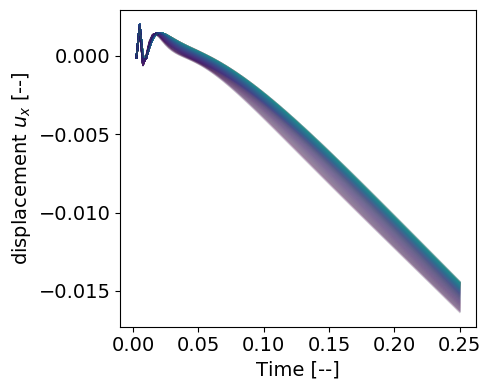

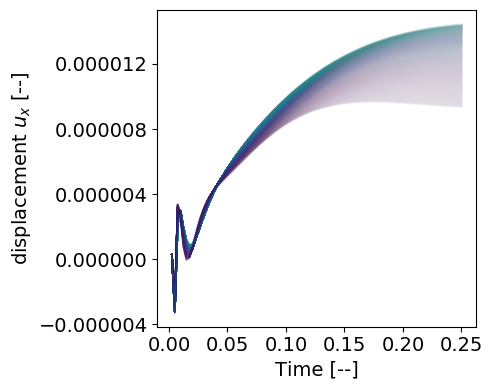

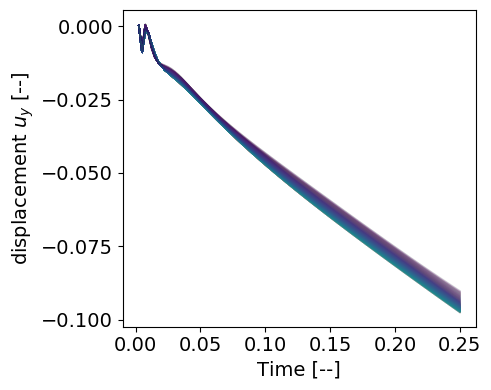

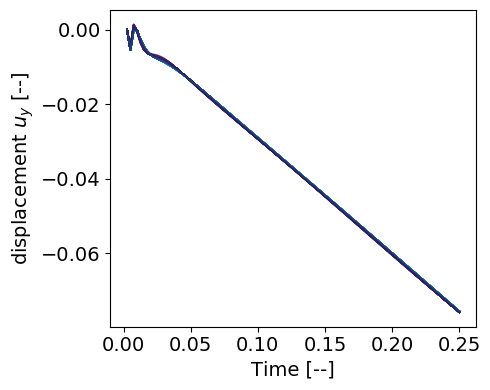

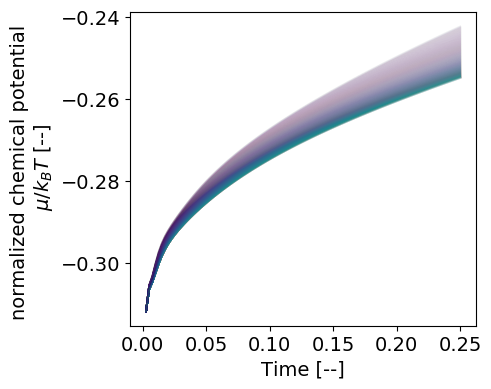

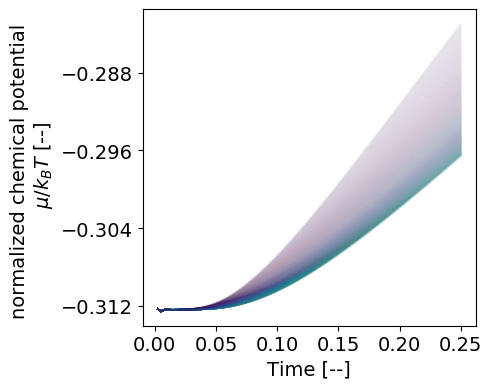

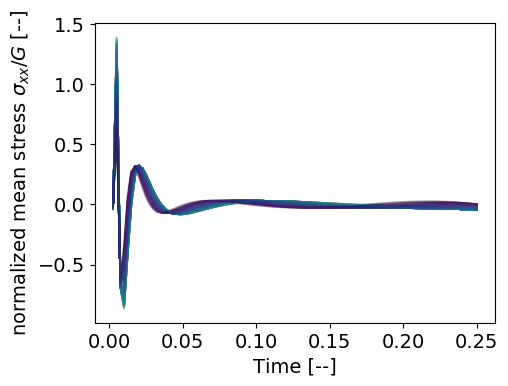

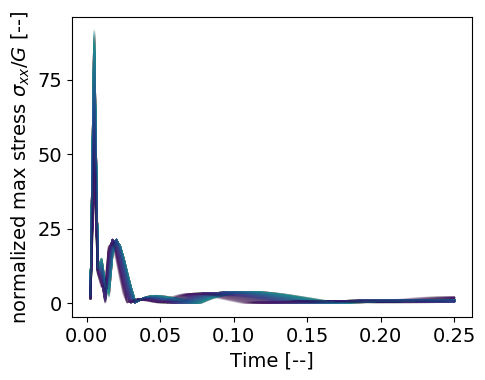

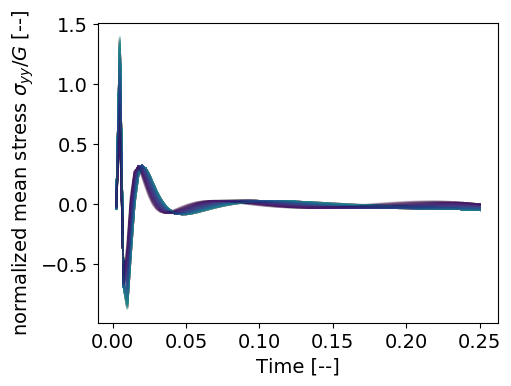

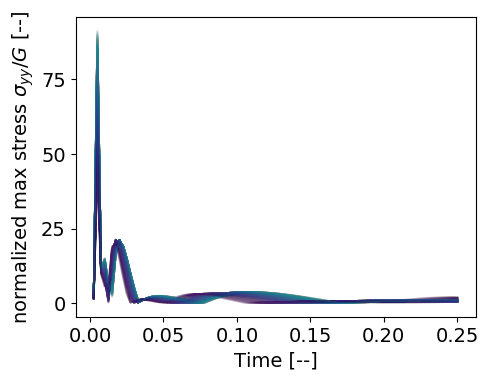

In [13]:
# Function to generate extended line styles
def extend_line_styles(num):
    base_styles = ['-', '--', '-.', ':']
    return base_styles * (num // len(base_styles)) + base_styles[:num % len(base_styles)]

# Function to plot the results for specific points
def plot_time_evolution(results, title, ylabel, key, point_index, line_styles, colormap, normalize, fig_name, alpha=0.01):
    if point_index >= len(points_of_interest):
        raise ValueError(f"Point index {point_index} is out of range. Available indices: 0 to {len(points_of_interest) - 1}")

    fig, ax = plt.subplots(figsize=(5, 4))
    point = points_of_interest[point_index]

    for i, param in enumerate(parameter_list):
        label = f"lambda={param[0]:.2f}, A={param[1]:.2f}, Point={point}"
        ax.plot(t_UQ[1:], results[i][point][:], color=colormap(normalize(i)), alpha=alpha, label=label)

    # labelLines([line for line in ax.get_lines()], align=False, zorder=2.5, color="k", fontsize=10, xvals=[0.8 + i for i in range(4)])

    ax.set_xlabel('Time [--]', fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

    # plt.title(title)
    # plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, fig_name), format='pdf')
    plt.show()

# Function to plot the mean or maximum stress values
def plot_mean_or_max_stress(results, title, ylabel, line_styles, colormap, normalize, fig_name, alpha=0.01):
    fig, ax = plt.subplots(figsize=(5, 4))

    for i, param in enumerate(parameter_list):
        label = f"lambda={param[0]:.2f}, A={param[1]:.2f}"
        ax.plot(t_UQ[1:], results[i], color=colormap(normalize(i)), alpha=alpha, label=label)

    # labelLines([line for line in ax.get_lines()], align=False, zorder=2.5, color="k", fontsize=10, xvals=[0.8 + i for i in range(4)])

    ax.set_xlabel('Time [--]', fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

    # plt.title(title)
    # plt.grid(True)
    plt.tight_layout()
    plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.9)
    plt.savefig(os.path.join(save_dir, fig_name), format='pdf')
    plt.show()

# Plot the results using a consistent style
nPoints = len(parameter_list)
points = np.arange(nPoints)
normalize = mcolors.Normalize(vmin=points.min(), vmax=points.max() * 2)
colormap = cm.viridis
line_styles = extend_line_styles(nPoints)

# Plot the displacement in the x-direction for point 0
plot_time_evolution(
    results['displacement_x'], "Time Evolution of Displacement (x)", 
    "displacement $u_x$ [--]", 'displacement_x', 0, 
    line_styles, colormap, normalize, "Fig_displacement_x_UQ_00_20240522.pdf"
)

# Plot the displacement in the x-direction for point 1
plot_time_evolution(
    results['displacement_x'], "Time Evolution of Displacement (x)", 
    "displacement $u_x$ [--]", 'displacement_x', 1, 
    line_styles, colormap, normalize, "Fig_displacement_x_UQ_050_20240522.pdf"
)

# Plot the displacement in the y-direction for point 0
plot_time_evolution(
    results['displacement_y'], "Time Evolution of Displacement (y)", 
    "displacement $u_y$ [--]", 'displacement_y', 0, 
    line_styles, colormap, normalize, "Fig_displacement_y_UQ_00_20240522.pdf"
)

# Plot the displacement in the y-direction for point 1
plot_time_evolution(
    results['displacement_y'], "Time Evolution of Displacement (y)", 
    "displacement $u_y$ [--]", 'displacement_y', 1, 
    line_styles, colormap, normalize, "Fig_displacement_y_UQ_050_20240522.pdf"
)

# Plot the chemical potential for point 0
plot_time_evolution(
    results['chemical_potential'], "Time Evolution of Chemical Potential", 
    "normalized chemical potential \n $\mu/k_B T$ [--]", 'chemical_potential', 
    0, line_styles, colormap, normalize, "Fig_chemical_potential_UQ_00_20240522.pdf"
)

# Plot the chemical potential for point 1
plot_time_evolution(
    results['chemical_potential'], "Time Evolution of Chemical Potential", 
    "normalized chemical potential \n $\mu/k_B T$ [--]", 'chemical_potential', 
    1, line_styles, colormap, normalize, "Fig_chemical_potential_UQ_050_20240522.pdf"
)

# Plot the mean stress in the xx direction
plot_mean_or_max_stress(
    results['mean_stress_xx'], "Time Evolution of Mean Stress (xx)", 
    "normalized mean stress $\sigma_{{xx}}/G$ [--]", 
    line_styles, colormap, normalize, "Fig_mean_stress_xx_UQ_20240522.pdf"
)

# Plot the max stress in the xx direction
plot_mean_or_max_stress(
    results['max_stress_xx'], "Time Evolution of Max Stress (xx)", 
    "normalized max stress $\sigma_{{xx}}/G$ [--]", 
    line_styles, colormap, normalize, "Fig_max_stress_xx_UQ_20240522.pdf"
)

# Plot the mean stress in the yy direction
plot_mean_or_max_stress(
    results['mean_stress_yy'], "Time Evolution of Mean Stress (yy)", 
    "normalized mean stress $\sigma_{{yy}}/G$ [--]", 
    line_styles, colormap, normalize, "Fig_mean_stress_yy_UQ_20240522.pdf"
)

# Plot the max stress in the yy direction
plot_mean_or_max_stress(
    results['max_stress_yy'], "Time Evolution of Max Stress (yy)", 
    "normalized max stress $\sigma_{{yy}}/G$ [--]", 
    line_styles, colormap, normalize, "Fig_max_stress_yy_UQ_20240522.pdf"
)